# Credit Risk Evaluation (Binary Classification Problem)

# Processes involved:
- Data cleaning
- Data wrangling
- Basic data analysis based on correlation
- Data prediction using:
    - Decision Tree: 71.8% accuracy
    - Random Forest: 74% accuracy
    - Deep Neural Net: 71.8% accuracy
    
_Acknowledgment: Dataset acquired from https://www.openml.org/d/31._

### Importing the dataset

In [428]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.externals.six import StringIO 
from sklearn.metrics import accuracy_score
from IPython.display import Image  
import pydotplus
import random

In [429]:
np.random.seed(7)

In [430]:
def load_data():
    df = pd.read_csv("dataset_31_credit-g.csv")
    return(df)

In [431]:
df = load_data()

In [432]:
df.head(5)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [433]:
df.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')

In [515]:
df.shape

(1000, 52)

### Encoding the values of columns into numeric (LabelEncoder and OneHotEncoder)

In [434]:
def encoder_onehot(data, column_name):
    """
    This function replaces the given column with a One-Hot encoded version of it,
    suitable for machine learning models. It also formats the column name into a
    more machine friendly version.
    
    Required libraries: from sklearn.preprocessing import OneHotEncoder, LabelEncoder
                        import pandas as pd
    
    Parameter:    data -        pandas.DataFrame
                  column_name - string
                  
    Return:       data -        modified pamdas.DataFrame
    """
    
    le = LabelEncoder()
    le_encoded = pd.Series(le.fit_transform(data[column_name]))
    vals = le_encoded.unique()
    inv = list(le.inverse_transform(vals))
    
    #Uncomment the 2 lines below to get better insight on the mapping of each value with each column
    #print("Column no. in encoded array: ", vals)
    #print("Column name: ", inv)
    
    ohe = OneHotEncoder(categories='auto')
    ohe_encoded_arr = ohe.fit_transform(le_encoded.values.reshape(-1,1)).toarray()
    cols = ["empty" for i in range(len(vals))]
    
    inv = [str.replace(" ", "_") for str in inv]
    inv = [str.replace("/", "_") for str in inv]
    inv = [str.replace("'", "") for str in inv]
    
    for i in range(len(vals)):
        cols[vals[i]] = column_name+"_"+str(inv[i])
        
    temp_df = pd.DataFrame(ohe_encoded_arr, columns = cols)
    data = pd.concat([data, temp_df], axis=1)
    data = data.drop([column_name], axis=1)
    
    return(data)

In [435]:
def encode_string_to_numeric(data):
    #A mapping of string values in the following columns to numeric values (compatible with ML models)
    #A manual mapping is done here since scikit-learn's LabelEncoder is unable to determine the sequential pattern
    checking_status_map = {"'<0'": 0,
                           "'no checking'": 1,
                           "'0<=X<200'": 2,
                           "'>=200'": 3}


    savings_status_map = {"'no known savings'": 0,
                          "'<100'": 1,
                          "'100<=X<500'": 2,
                          "'500<=X<1000'": 3,
                          "'>=1000'": 4}

    employment_map = {"'<1'": 0,
                      "'1<=X<4'": 1,
                      "'4<=X<7'": 2,
                      "'>=7'": 3}

    # changing some column values to numeric

    data["checking_status"] = data["checking_status"].map(checking_status_map)
    data["savings_status"] = data["savings_status"].map(savings_status_map)
    data["employment"] = data["employment"].map(employment_map)
    
    #The following are all the columns that need one-hot encoding
    ohe_cols = ["credit_history", "purpose", "other_parties", "job", "other_payment_plans", "property_magnitude",
               "housing", "own_telephone", "foreign_worker", "personal_status", "class"]
    
    for col in ohe_cols:
        data = encoder_onehot(data, col)
        
    data = data.astype("float64")
    data = data.fillna(0)
    
    return (data)

In [436]:
df = encode_string_to_numeric(df)

We have used sequential numerical values (such as 1, 2, 3, 4, ...) because it make sense as the above 3 columns have categories in some sequence (ascending/descending). For other categorical string columns, we will use OneHotEncoder.

In [437]:
df.columns

Index(['checking_status', 'duration', 'credit_amount', 'savings_status',
       'employment', 'installment_commitment', 'residence_since', 'age',
       'existing_credits', 'num_dependents', 'credit_history_all_paid',
       'credit_history_critical_other_existing_credit',
       'credit_history_delayed_previously', 'credit_history_existing_paid',
       'credit_history_no_credits_all_paid', 'purpose_domestic_appliance',
       'purpose_new_car', 'purpose_used_car', 'purpose_business',
       'purpose_education', 'purpose_furniture_equipment', 'purpose_other',
       'purpose_radio_tv', 'purpose_repairs', 'purpose_retraining',
       'other_parties_co_applicant', 'other_parties_guarantor',
       'other_parties_none', 'job_high_qualif_self_emp_mgmt',
       'job_unemp_unskilled_non_res', 'job_unskilled_resident', 'job_skilled',
       'other_payment_plans_bank', 'other_payment_plans_none',
       'other_payment_plans_stores', 'property_magnitude_life_insurance',
       'property_magnit

Now our dataFrame is in complete numeric form and ready for any kind of statistical analysis or machine learning.

### Analyzing any correlation between columns

In [438]:
df[["class_good", "class_bad"]].describe()

,class_good,class_bad
count,1000.000000,1000.000000
mean,0.700000,0.300000
std,0.458487,0.458487
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


Roughly 70% of the people have good class (meaning low credit risk) while the rest 30% are in bad class. Let's see if we can find any correlation between the variables.

In [439]:
corr = df.corr()
corr["class_bad"].sort_values(ascending=False)

class_bad                                        1.000000
duration                                         0.214927
credit_amount                                    0.154739
credit_history_no_credits_all_paid               0.144767
credit_history_all_paid                          0.134448
property_magnitude_no_known_property             0.125750
purpose_new_car                                  0.096900
other_payment_plans_bank                         0.096510
housing_rent                                     0.092785
foreign_worker_yes                               0.082079
housing_for_free                                 0.081556
personal_status_female_div_dep_mar               0.075493
installment_commitment                           0.072404
purpose_education                                0.070088
other_parties_co_applicant                       0.062728
other_payment_plans_stores                       0.050523
personal_status_male_div_sep                     0.050063
credit_history

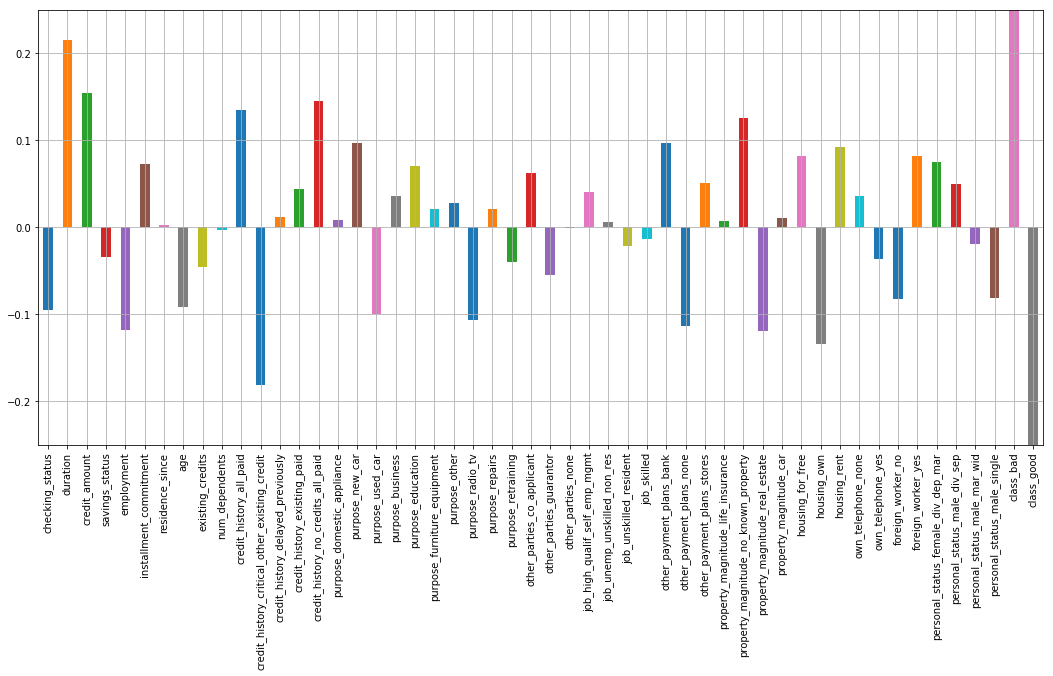

In [440]:
plt.figure(figsize=(18,8))
corr["class_bad"].plot.bar()
plt.grid()
plt.ylim(-0.25,0.25)
plt.show()

__Some interesting cases (correlation between bad class and other columns):__

- Duration: This column has the highest correlation with bad credit risk class. This makes sense because the longer someone is in debt, the higher their chances of being at credit risk.

- Credit Amount: Since higher borrowing cost is associated with higher credit risk, a positive correlation is expected.

- Employment: A higher number in employment category means an increased ability to earn more and pay off their debt, thus resulting in a negative correlation.

(Similarly there are other trends that can be analyzed.)

### Implenting Machine Learning

In [441]:
X = df.drop(["class_bad", "class_good"], axis=1)
y = df[["class_bad", "class_good"]]

In [509]:
#Defining functions for each of the 3 classifiers

def DT_clf(X_train, X_test, y_train, y_test):
    
    DTC = DecisionTreeClassifier(max_leaf_nodes=5, random_state=7)
    DTC.fit(X_train, y_train)
    
    y_pred = DTC.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    #print("Accuracy of the model = ",acc)
    
    return(DTC, acc)

def RF_clf(X_train, X_test, y_train, y_test):
    
    rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=20, n_jobs=-1, random_state=7)
    rnd_clf.fit(X_train, y_train)
    
    y_pred = rnd_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    #print("Accuracy of the model = ",acc)
    
    return(rnd_clf, acc)

def DNN_clf(X_train, X_test, y_train, y_test):
    
    n_cols = X_train.shape[1]

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(50, activation=tf.nn.sigmoid, input_shape=(n_cols,)), #input layer
        tf.keras.layers.Dense(25, activation=tf.nn.sigmoid),                        #hidden 1
        tf.keras.layers.Dense(25, activation=tf.nn.sigmoid),                        #hidden 2
        tf.keras.layers.Dense(2, activation=tf.nn.softmax)                          #output
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=30, verbose=0)
    
    acc = model.evaluate(X_test, y_test, verbose=0)[1]
    
    #print("Accuracy of the model = ",acc)
    
    return(model, acc)

In [510]:
#This function trains the required model

classifier = ["DTF", "RFC", "DNN"]

def train_model(clf, X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    
    if clf == "DTF":
        
        model, acc = DT_clf(X_train, X_test, y_train, y_test)
        
    if clf == "RFC":
        
        model, acc = RF_clf(X_train, X_test, y_train, y_test)
        
    if clf == "DNN":
        
        model, acc = DNN_clf(X_train, X_test, y_train, y_test)
        
    return(model, acc)

In [511]:
#test case

class_enc = ["Bad", "Good"]

model, acc = train_model(classifier[1], X, y)
pred = model.predict(X_test.iloc[[5]])

print("Predicted Class: ",class_enc[pred.argmax()]," - Accuracy: ", acc)
print("Actual Class: ",class_enc[y_test.iloc[[5]].values.argmax()])

Predicted Class:  Good  - Accuracy:  0.7484848484848485
Actual Class:  Good


In [514]:
#Accuracy for each classifier

accuracy = {}

for c in classifier:
    print("Training ",c)
    model, accuracy[c] = train_model(c, X, y)
    
print("Accuracy = ",accuracy)

Training  DTF
Training  RFC
Training  DNN
Accuracy =  {'DNN': 0.7212121215733615, 'DTF': 0.7363636363636363, 'RFC': 0.7484848484848485}


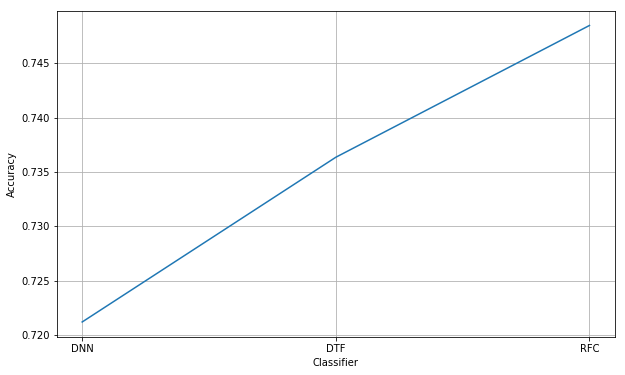

In [513]:
#Accuracy of each classifier plotted

plt.figure(figsize=(10,6))
plt.plot(accuracy.keys(), accuracy.values())
plt.grid()
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.show()

### Conclusion

The maximum accuracy achieved in this project is 74.8% by Random Forest Classifier. Amongst the  411,000+ runs listed on _openml.org_, this classifier ranks as one of the top 15 classifiers in terms of accuracy. This accuracy can easily be increased by further removing the columns that have low correlation with the classes. Further, we can check for better hyperparameters using ```GridSearchCV``` for multiple paramters, given we have a powerful CPU/GPU.

## Supplementary

__1. Accuracy of each classifier vs no. of sample points:__

In [525]:
classifier = ["DTF", "RFC", "DNN"]
test_size = [0.99, 0.95, 0.9, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.30, 0.25, 0.20]
n = []
dtf = []
rfc = []
dnn = []
    
for s in test_size:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=s, random_state=1)
    n_ = X_train.shape[0]
    n.append(n_)
        
    for c in classifier:
        if c == "DTF":
            print("Training ",c, " -- test_size = ",s)
            model, acc = DT_clf(X_train, X_test, y_train, y_test)
            dtf.append(acc)
                
        if c == "RFC":
            print("Training ",c, " -- test_size = ",s)
            model, acc = RF_clf(X_train, X_test, y_train, y_test)
            rfc.append(acc)
                
        if c == "DNN":
            print("Training ",c, " -- test_size = ",s)
            model, acc = DNN_clf(X_train, X_test, y_train, y_test)
            dnn.append(acc)

Training  DTF  -- test_size =  0.99
Training  RFC  -- test_size =  0.99
Training  DNN  -- test_size =  0.99
Training  DTF  -- test_size =  0.95
Training  RFC  -- test_size =  0.95
Training  DNN  -- test_size =  0.95
Training  DTF  -- test_size =  0.9
Training  RFC  -- test_size =  0.9
Training  DNN  -- test_size =  0.9
Training  DTF  -- test_size =  0.85
Training  RFC  -- test_size =  0.85
Training  DNN  -- test_size =  0.85
Training  DTF  -- test_size =  0.8
Training  RFC  -- test_size =  0.8
Training  DNN  -- test_size =  0.8
Training  DTF  -- test_size =  0.75
Training  RFC  -- test_size =  0.75
Training  DNN  -- test_size =  0.75
Training  DTF  -- test_size =  0.7
Training  RFC  -- test_size =  0.7
Training  DNN  -- test_size =  0.7
Training  DTF  -- test_size =  0.65
Training  RFC  -- test_size =  0.65
Training  DNN  -- test_size =  0.65
Training  DTF  -- test_size =  0.6
Training  RFC  -- test_size =  0.6
Training  DNN  -- test_size =  0.6
Training  DTF  -- test_size =  0.55
Trai

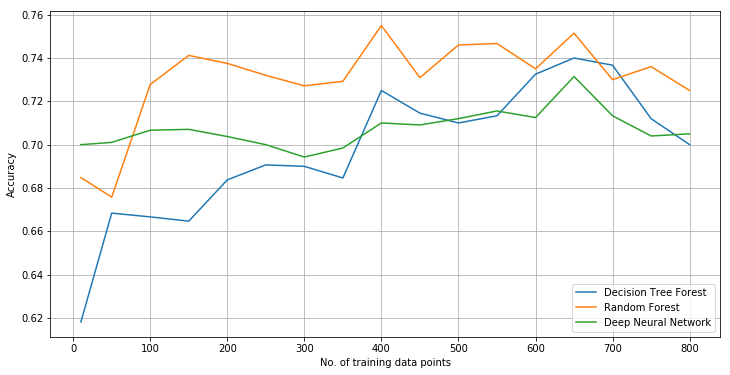

In [526]:
plt.figure(figsize=(12,6))
plt.plot(n, dtf, label="Decision Tree Forest")
plt.plot(n, rfc, label="Random Forest")
plt.plot(n, dnn, label="Deep Neural Network")
plt.legend()
plt.xlabel("No. of training data points")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

__2. Finding best hyperparameter for Decision Tree Classifier__

A quick 10-fold cross-validation grid search is done to determine the best ```max_leaf_nodes``` hyperparameter.

In [337]:
DTC = DecisionTreeClassifier() #choice of classifier
mln = np.arange(2,30) #range of max_leaf_nodes values to check
md = np.arange(2,30)
parameters = {'max_leaf_nodes':mln}
clf = GridSearchCV(DTC, parameters, cv=10) #5-fold Cross-Validation GridSearch to determine the best hyperparameter
clf.fit(X_train, y_train) #fit the training dataset

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'mean_test_score')

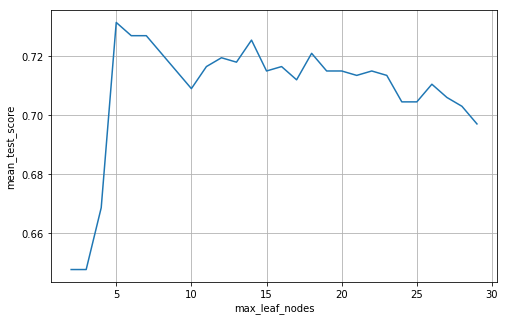

In [338]:
#plot the performance
plt.figure(1, figsize=(8,5))
m = "mean_test_score"
plt.plot(mln, clf.cv_results_[m])
plt.grid()
plt.xlabel('max_leaf_nodes')
plt.ylabel(m)

In [339]:
#Find the best value
best_max_leaf_nodes_idx = clf.cv_results_[m].argmax()

best_max_leaf_nodes = mln[best_max_leaf_nodes_idx]
best_max_leaf_nodes

5

Below is the entire decision tree classifier structure.

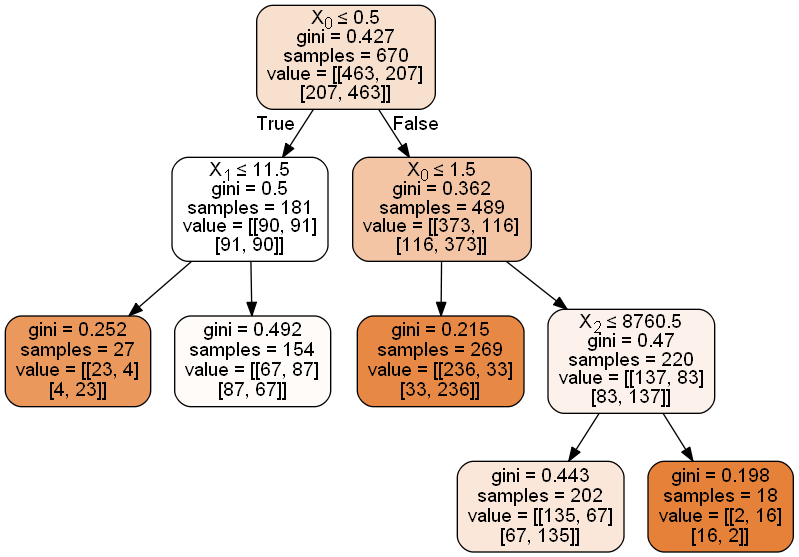

In [342]:
dot_data = StringIO()
export_graphviz(DTC, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

__3. Finding best hyperparameter for Random Forest Classifier__

Since Random Forest Classifier is more computing intesnive, we do a 5-fold search instead of 10-fold to find the best ```max_leaf_nodes``` hyperparameter.

In [343]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1) #choice of classifier
mln = np.arange(2,30) #range of max_leaf_nodes values to check
parameters = {'max_leaf_nodes':mln}
clf = GridSearchCV(rnd_clf, parameters, cv=5) #5-fold Cross-Validation Search to determine the best hyperparameter
clf.fit(X_train, y_train) #fit the training dataset

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'mean_test_score')

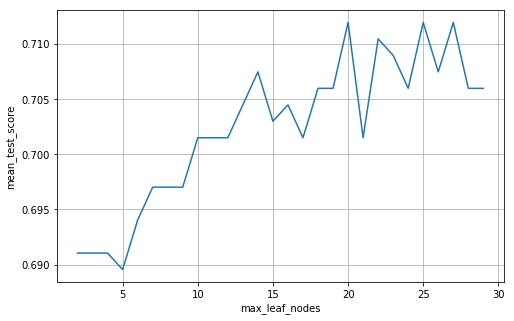

In [344]:
#plot the performance
plt.figure(1, figsize=(8,5))
m = "mean_test_score"
plt.plot(mln, clf.cv_results_[m])
plt.grid()
plt.xlabel('max_leaf_nodes')
plt.ylabel(m)

In [345]:
#Find the best value
best_max_leaf_nodes_idx = clf.cv_results_[m].argmax()

best_max_leaf_nodes = mln[best_max_leaf_nodes_idx]
best_max_leaf_nodes

20